<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Model Predictive Control: Exercise 2

Your goal is to implement an interior-point method to solve the following quadratic program:
$$
\begin{align*}
\min \quad & \frac{1}{2} z^T H z + q^T z \\
\text{s.t.} \quad & Gz \leq d 
\end{align*}
$$
The complete algorithm can be found in the lecture notes.
You will implement it in a function `qpsol()` that takes as input the problem data (matrices and vectors $H, q, G, d$) and returns the optimal solution $z^*$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
import time
import mpt4py

np.random.seed(123)

Here are some utility functions that are given for you

In [4]:
def random_qp(dim: int) -> dict:
    """Generate a dictionary containing the problem data for a random quadratic program."""
    G = np.random.randn(5*dim, dim)
    d = np.ones(5*dim)
    H = np.random.randn(dim, dim)
    H = H@H.T
    q = np.random.randn(dim)
    return {
        # problem data
        "G": G, "d": d, "H": H, "q": q,
        # helper functions
        "f": lambda z: 0.5 * z.T @ H @ z + q.T @ z,
        "grad_f": lambda z: H @ z + q,
        "phi": lambda z: np.sum(-np.log(d - G @ z)),
        "grad_phi": lambda z: np.sum(G.T /(d - G @ z), 1),
    }

def create_settings(dim: int, speed: str):
    """Generate a dictionary containing the optimization settings."""
    # we chose d = 1, so the point 0 is always feasible
    z0 = np.zeros(dim)
    if speed == "slow":
        return {
            "kappa0": 100,
            "alpha": 0.02,
            "beta": 0.9,
            "mu": 0.8,
            "epsilon": 1e-3,
            "slow": True,
            "z0": z0,
        }
    elif speed == "fast":
        return {
            "kappa0": 1,
            "alpha": 0.02,
            "beta": 0.7,
            "mu": 1e-2,
            "epsilon": 1e-8,
            "slow": False,
            "z0": z0,
        }
    else:
        raise ValueError(f"Speed argument should be 'fast' or 'slow' but is {speed}")

def plot_optimization(prob: dict, sol: dict, sol_ref: dict):
    """Plot the inner and outer iterations of the optimizer. Only works for 2D search spaces."""

    if prob["H"].shape[0] != 2:
        raise ValueError("Plotting is only supported for 2D problems")

    fig, ax = plt.subplots(figsize=(13, 8))

    # plot feasible set
    feasible_set = mpt4py.Polyhedron.from_Hrep(prob["G"], prob["d"])
    feasible_set.plot(ax, color="lightgray", opacity=0.5)

    # plot bounding box of feasible set 
    bbox = mpt4py.Polyhedron.bounding_box(feasible_set)
    xmax = np.max(bbox.Vrep.V[:,0])
    xmin = np.min(bbox.Vrep.V[:,0])
    ymax = np.max(bbox.Vrep.V[:,1])
    ymin = np.min(bbox.Vrep.V[:,1])
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='r'))
    ax.set_xlim(xmin - 0.1, xmax + 0.1)
    ax.set_ylim(ymin - 0.1, ymax + 0.1)

    # plot contours of cost function
    X,Y = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
    F = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            F[i,j] = prob["f"](np.array([X[i,j], Y[i,j]]))
    ax.contour(X, Y, F)

    # plot initial point and reference solution
    ax.scatter(settings["z0"][0], settings["z0"][1], color="blue", label="Initial Point", zorder=10)
    ax.scatter(sol_ref["zopt"][0], sol_ref["zopt"][1], color="green", label="Reference Solution", zorder=10)


    # plot iterates
    if sol is not None:
        ax.plot(sol["inner_iterates"][0], sol["inner_iterates"][1], color="purple", label="Inner Iterates", zorder=3)
        ax.scatter(sol["outer_iterates"][0], sol["outer_iterates"][1], color="orange", label="Outer Iterates", zorder=5)

    # final details
    ax.legend()
    fig.tight_layout()

def qpsol_ref(prob: dict, settings: dict):
    """Reference QP solver using the OSQP library."""
    start = time.perf_counter()
    sol = solve_qp(prob["H"], prob["q"], prob["G"], prob["d"], solver="osqp")
    stop = time.perf_counter()
    return {"zopt":sol, "fopt": prob["f"](sol), "solve_time": stop - start}

## Problem 1: Implement the interior point method

### Task 1
Complete the function `qpsol` below that implements the interior point method discussed in class.
You only have to complete the code between the `# YOUR CODE HERE` comments.

> _Hint_: You can access the problem data from the `prob` dictionary with `prob["H"]`, `prob["q"]`, `prob["G"]`, and `prob["d"]`.
> _Hint_: You can use the function `np.linalg.solve` to solve a linear system, the same way you would use `\` in Matlab.

In [47]:
def qpsol(prob: dict, settings: dict)->dict:
    # initialization
    kappa = settings["kappa0"]
    z = np.copy(settings["z0"])
    outer_iterates = [np.copy(z)]
    inner_iterates = [np.copy(z)]

    dim = prob["G"].shape[1]

    # outer loop
    start = time.perf_counter()
    while kappa > settings["epsilon"]:
        # inner loop
        while True: 
            if np.any(prob["d"] - prob["G"] @ z < 0):
                raise ValueError("Current point z is not feasible")
            
            # TODO: add your code for the search direction Dz
            grad_phi = prob["grad_phi"](z)
            grad_f = prob["grad_f"](z)

            s = prob["d"] - prob["G"] @ z
            sG = (prob["G"].T / s).T
            hess_phi = sG.T @ sG

            hess_f = prob["H"]

            Dz = np.linalg.solve(hess_f + kappa*hess_phi, -(grad_f + kappa*grad_phi))
            
            # line search
            t = 1.0
            # reduce t until z+ = z + t * Dz is feasible
            while t > settings["epsilon"] and np.any(prob["G"] @ (z + t * Dz) > prob["d"]):
                t *= settings["beta"]
            
            # reduce t to minimize f(z + t * Dz)
            while t > settings["epsilon"]:
                fup = prob["f"](z + t*Dz) + kappa * prob["phi"](z+t*Dz)
                df = prob["grad_f"](z) + kappa * prob["grad_phi"](z)
                fdown = prob["f"](z) + kappa * prob["phi"](z) + settings["alpha"] * t * df.T @ Dz
                if fup < fdown: 
                    break
                t *= settings["beta"]

            # termination condition
            # we stop if we're no longer making any progress,
            # either because the step size t is very small,
            # or the size of the gradient is very small
            if t < settings["epsilon"] or np.linalg.norm(Dz) < settings["epsilon"]:
                break

            # slow down convergence so we can see whats going on
            if settings["slow"]:
                t = min(t, t/(20 * np.linalg.norm(Dz)))
            
            # take step
            z += t * Dz

            inner_iterates.append(np.copy(z))
        
        # decrease barrier parameter
        kappa *= settings["mu"]
        outer_iterates.append(np.copy(z))

    stop = time.perf_counter()
    outer_iterates= np.column_stack(outer_iterates)
    inner_iterates= np.column_stack(inner_iterates)
    return {"zopt": z, "fopt": prob["f"](z), "solve_time": stop - start, "outer_iterates": outer_iterates, "outer_iterations": outer_iterates.shape[1], "inner_iterates": inner_iterates, "inner_iterations": inner_iterates.shape[1]}

Run the following cells to test your implementation against the reference implementation. 
The plot displays:
- the level lines of the quadratic function we want to optimize
- the polytopic feasible set
- the inner and outer iterations of your `qpsol` optimizer.
- the solution found by `qpsol_ref`.

In [66]:
dim = 2
prob = random_qp(dim)
settings = create_settings(dim, speed="slow")

--------------------------
Your optimal cost: -0.06403066830724452
True optimal cost: -0.06403589617737585
Error: 5.227870131324641e-06
--------------------------
Your optimal solution: [ 0.18999566 -0.17751702]
True optimal solution: [ 0.18721887 -0.18194275]
Norm of error: 0.005224718716139167
--------------------------
Solution statistics:
	Number of outer iterations: 53
	Number of inner iterations: 39
	Solve time: 6.5319 ms
	Reference solve time: 1.8141 ms


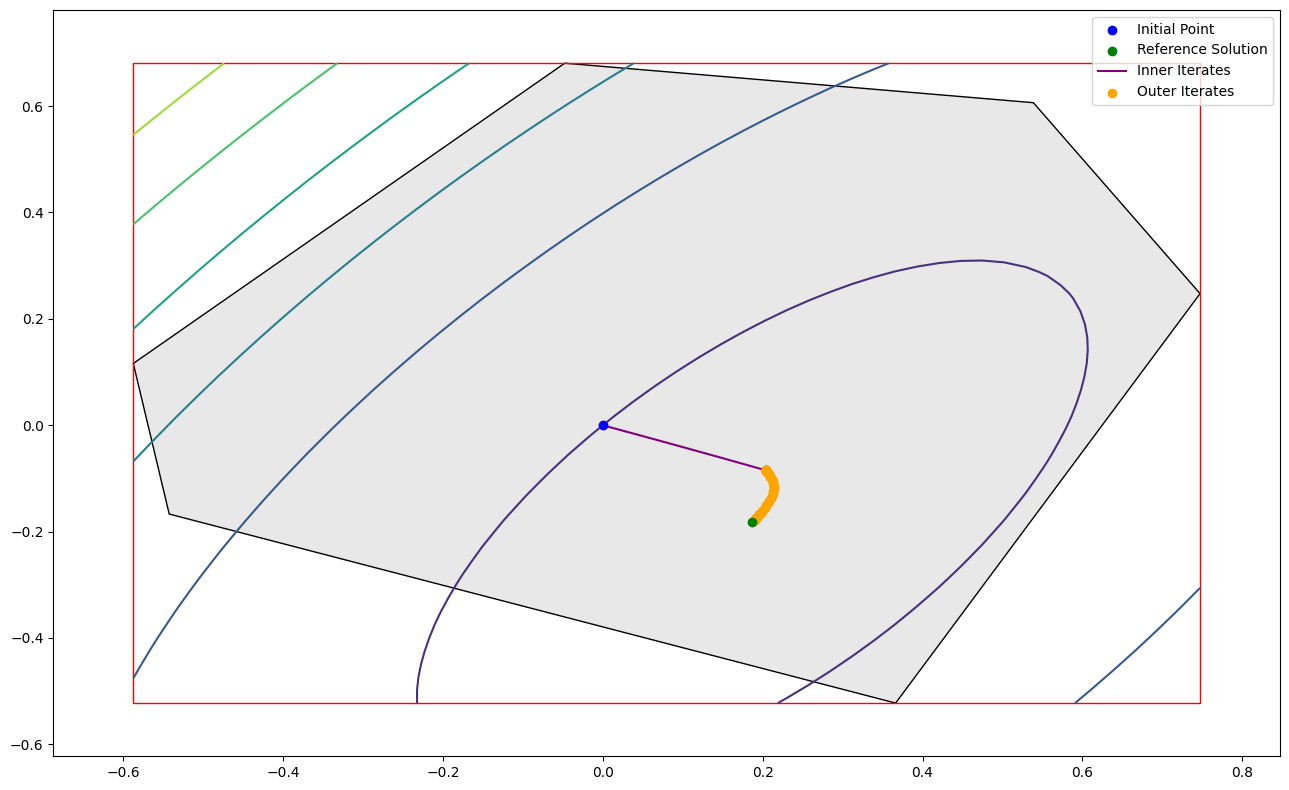

In [67]:
sol = qpsol(prob, settings)
sol_ref = qpsol_ref(prob, settings)
print("--------------------------")
print(f"Your optimal cost: {sol['fopt']}")
print(f"True optimal cost: {sol_ref['fopt']}")
print(f"Error: {np.abs(prob['f'](sol['zopt']) - sol_ref['fopt'])}")
print("--------------------------")
print(f"Your optimal solution: {sol['zopt']}")
print(f"True optimal solution: {sol_ref['zopt']}")
print(f"Norm of error: {np.linalg.norm(sol['zopt'] - sol_ref['zopt'])}")
print("--------------------------")
print("Solution statistics:")
print(f"\tNumber of outer iterations: {sol['outer_iterations']}")
print(f"\tNumber of inner iterations: {sol['inner_iterations']}")
print(f"\tSolve time: {1000*sol['solve_time']:.4f} ms")
print(f"\tReference solve time: {1000*sol_ref['solve_time']:.4f} ms")
plot_optimization(prob, sol, sol_ref)

## Problem 2: Study the influence of the hyperparameters

In the cells above, we set the `speed` argument to `"slow"`, which chose the hyperparameters $\mu, \beta, \alpha$, etc. in such a way that the convergence of `qpsol` is slowed down for better visualization. 
Changing `speed` to `"fast"` will set these parameters to 'normal' values and the algorithm will now converge so quickly that you won't be able to see the central path.

### Task 1

To further understand the effect of these hyperparameters, generate a plot of the total numbers of Newton steps as a function of the $\mu$ hyperparameter. 
Choose values for $\mu$ between $1e-3$ and $0.9$ using a log scale, and let the `speed="fast"` setting choose the other values. 
For each value of $\mu$, average the number of iterations over multiple random problem instances.

> _Hint_: Remember the Newton steps correspond to the outer iterations, which you can access from the solution dictionary returned by `qpsol` with `sol["outer_iterates"].shape[1]`.

> _Hint_: You can access the $\mu$ hyperparameter with `settings["mu"]`.

> _Hint_: You can generate values on a log scale using the `np.logspace` function. You can plot values with a log scale on the x-axis using `plt.semilogx`.

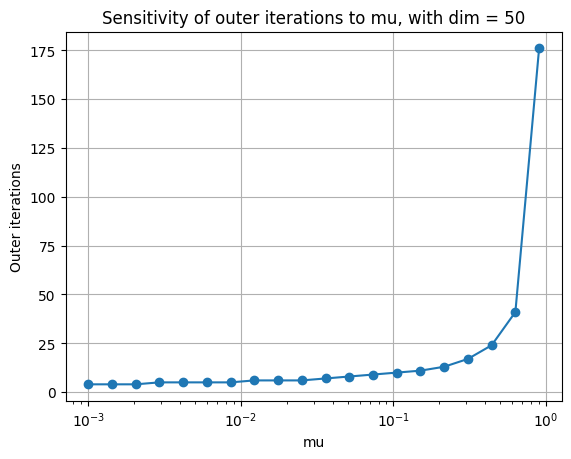

In [77]:
# TODO: Your code here
MU = np.logspace(-3, np.log10(0.9), 20)
nt_steps = []
dim = 50
iter = 50


for mu in MU:
    nt_steps_mu = []
    settings = create_settings(dim, speed="fast")
    settings["mu"] = mu
    for i in range(iter):
        prob = random_qp(dim)
        sol = qpsol(prob, settings)
        nt_steps_mu.append(sol["outer_iterates"].shape[1])
        
    average = sum(nt_steps_mu)/iter
    nt_steps.append(average)

plt.semilogx(MU, nt_steps, 'o-', )
plt.title("Sensitivity of outer iterations to mu, with dim = " + str(dim))
plt.xlabel("mu")
plt.ylabel("Outer iterations")
plt.grid(True)

### Task 2

Change the problem dimension to 50. How does the number of iterations change?

(You can reuse the cells above to answer this question).

*Answer:* Very little change ! Here are both plots in comparison, for dim = 2 and dim = 50 :

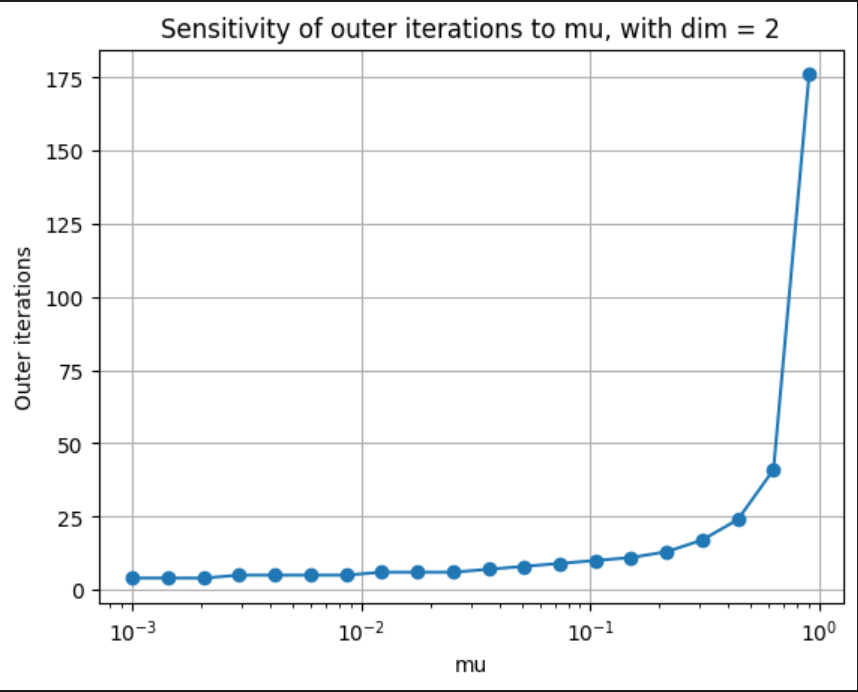 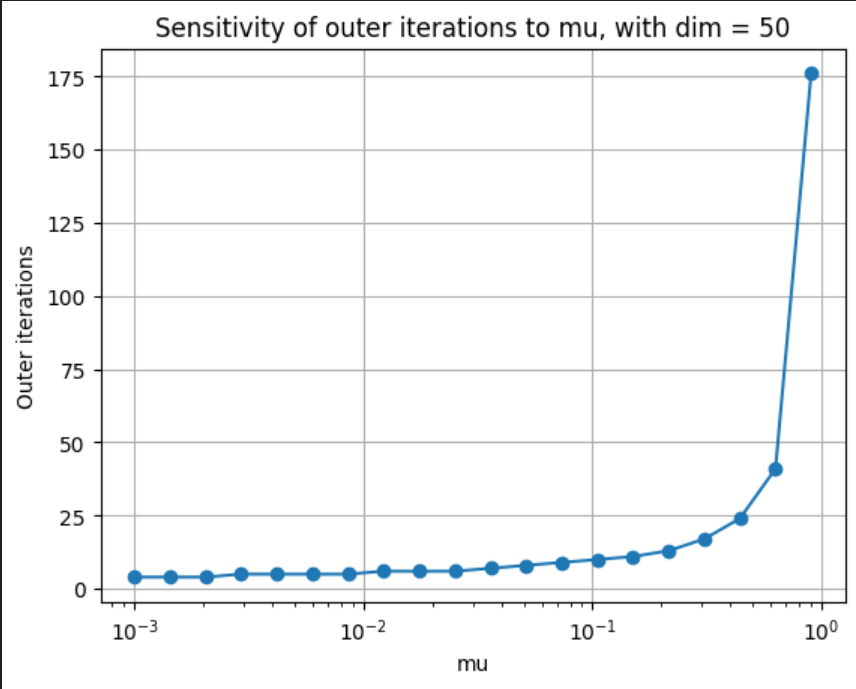